## Information

- Author: Andy Tzanidakis (atzanida@uw.edu)
- University of Washington

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma
import matplotlib
from astropy.coordinates import SkyCoord
cm = matplotlib.cm.get_cmap('jet')

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from tqdm import tqdm

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

from lsst.rsp import get_tap_service, retrieve_query
service = get_tap_service()

from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from tqdm import tqdm 
from astropy.table import Table
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker as plticker
import matplotlib.patches as patches
import pandas as pd

from astropy import units as u
from astropy import visualization as aviz

import lsst.daf.butler as dafButler
import lsst.geom
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.decam import DarkEnergyCamera


In [60]:
import cutoutpipe as cutpipe # cutout scripts!

## Initiate Tap Service

In [5]:
# create the TAP service client
service = get_tap_service()

# we will all use the same input coordinates and radii
center_coords = "62, -32"

radius_deg = 1 # degrees

## Query DiaObject

In [6]:
results = service.search("SELECT ra, decl, gPSFluxSigma, rPSFluxSigma, nDiaSources, diaObjectId, "
                         "uPSFluxNdata, gPSFluxNdata, rPSFluxNdata, iPSFluxNdata, zPSFluxNdata, yPSFluxNdata, rPSFluxMax, "
                         "scisql_nanojanskyToAbMag(uPSFluxMax) as u_psf_mag, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) as g_psf_mag, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) as r_psf_mag, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) as i_psf_mag, "
                         "scisql_nanojanskyToAbMag(zPSFluxMax) as z_psf_mag, "
                         "scisql_nanojanskyToAbMag(yPSFluxMax) as y_psf_mag "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         f"CIRCLE('ICRS', {center_coords}, {radius_deg})) = 1 "
                        "AND uPSFluxChi2 > 0 "
                        "AND gPSFluxChi2 > 0 "
                        "AND rPSFluxChi2 > 0 "
                        "AND iPSFluxChi2 > 0 "
                        "AND zPSFluxChi2 > 0 "
                        "AND yPSFluxChi2 > 0 ")

table = results.to_table()

In [12]:
table[0], f"DIAObjectID: {table[0]['diaObjectId']}"  # display the first index

(<Row index=0>
     ra         decl    gPSFluxSigma  rPSFluxSigma nDiaSources     diaObjectId     uPSFluxNdata gPSFluxNdata rPSFluxNdata iPSFluxNdata zPSFluxNdata yPSFluxNdata   rPSFluxMax      u_psf_mag     g_psf_mag r_psf_mag i_psf_mag z_psf_mag     y_psf_mag     
    deg         deg                                                                                                                                                                                                                                        
  float64     float64     float64       float64       int64           int64          float64      float64      float64      float64      float64      float64       float64         float64       float64   float64   float64   float64       float64      
 ---------- ----------- ------------ ------------- ----------- ------------------- ------------ ------------ ------------ ------------ ------------ ------------ ------------- ----------------- --------- --------- --------- ------

In [14]:
# information we're going to use for this demo
c_targ = "61.8245052, -32.8523419"
_id = 1823562024899051852

## Fetch Information from `DiaSource` given the `DiaObjectID`

In [18]:
def xmatch_diasource(cent_coord, diaObjID, rad=0.1):
    """Return DiaSource table containing: ra, decl, filterNmae, ccdVisitId"""
    
    return service.search(f"SELECT ra, decl, filterName, ccdVisitId "
                  "FROM dp02_dc2_catalogs.DiaSource "
                 "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                 f"CIRCLE('ICRS', {cent_coord}, {rad})) = 1 "
                  f"AND diaObjectId = {diaObjID}").to_table()

In [24]:
# id's of all visits & filters
xmatch_diasource(c_targ, _id)[0]

ra,decl,filterName,ccdVisitId
deg,deg,,
float64,float64,object,int64
61.8245295,-32.8523745,u,200751030


## Use Xmatch DiaSource Information to Fetch Visit Information from `Source`

In [51]:
def xmatch_source(cent_coord, ccd_vis, rad=0.01):
    _table = service.search(f"SELECT ra, decl, coord_ra, coord_dec, ccdVisitId, "
                      "band, instrument, "
                      "visit, sourceId, detector "
                  "FROM dp02_dc2_catalogs.Source "
                 "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                 f"CIRCLE('ICRS', {cent_coord}, {rad})) = 1 "
                  f"AND ccdVisitId = {ccd_vis}").to_table()
    
    # In crowded fields we suspect this will cause issues; let's to the closest x-match based on location
    targ_pos = SkyCoord(ra=float(cent_coord.split(",")[0])*u.deg, dec=float(cent_coord.split(",")[1])*u.deg)
    table_pos = SkyCoord(ra=_table['ra'], dec=_table['decl'])    
    d_sep = targ_pos.separation(table_pos).arcsecond
    
    match = np.argmin(d_sep)
    return _table[match]

In [53]:
xmatch_source("61.8245295,-32.8523745", 200751030)

ra,decl,coord_ra,coord_dec,ccdVisitId,band,instrument,visit,sourceId,detector
deg,deg,deg,deg,,,,,,
float64,float64,float64,float64,int64,object,str13,int64,int64,int64
61.8245859,-32.8524261,61.8245859,-32.8524261,200751030,u,LSSTCam-imSim,200751,107777388561039394,30


In [55]:
my_visit_info = xmatch_source("61.8245295,-32.8523745", 200751030)

## Set-up Butler

In [54]:
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2') # call butler
registry = butler.registry # fetch registry

## Set-up CutOutQuery Dict

In [57]:
# Visit Information Dict
vis_info = {"visit": my_visit_info['visit'], "band": my_visit_info['band'], "instrument":my_visit_info['instrument'], "detector":my_visit_info['detector']}

# Sphere 2Sky
my_spherePoint = lsst.geom.SpherePoint(my_visit_info['ra']*lsst.geom.degrees, my_visit_info['decl']*lsst.geom.degrees)


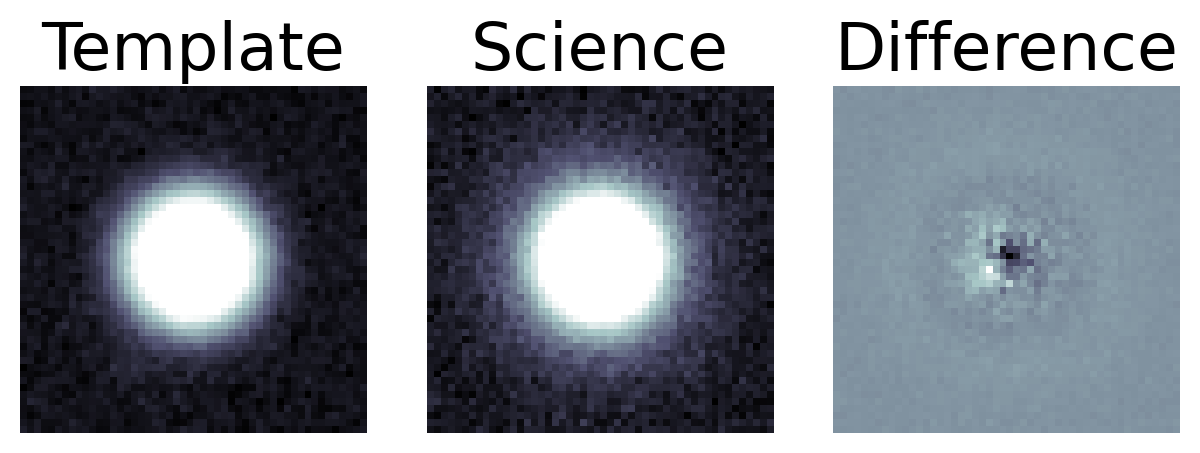

In [59]:
outp = cutpipe.retrieveCutouts(butler, vis_info, '2.2i/runs/DP0.2', my_spherePoint, lsst.geom.Extent2I(50, 50))
cutpipe.plotCutout(*outp)